# Lineare Regression mit Gradientenabstieg

<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

In [122]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [7]:
%matplotlib notebook
# %load_ext tikzmagic


from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, axes3d
import matplotlib.gridspec as gridspec
import numpy as np
from numpy.random import normal
from time import sleep

Sei $f : x \mapsto mx + b$ die Funktion, die unsere Daten modellieren soll. Die Fehlerfunktion $e$ ist die Summe der Quadrate der Distanzen zwischen Vorhersagen von $f$ und Zielwerten aus dem Datensatz, auf den $f$ trainiert werden soll:

$$e : X, Y \mapsto \frac{1}{N} \sum_{i=1}^N (y_i -f(x_i))^2$$

wobei $N = |X| = |Y|$ und $x_i \in X$ sowie $y_i \in Y$.

Um $f$ den Daten anzupassen, gilt es, die Fehlerfunktion zu minimieren. Hierzu suchen wir also nach dem Minimum von $e$ und passen iterativ die Parameter von $f$ entsprechend der Steigungen von $e$ in der $m$- sowie der $b$-Dimension am Punkt $(m,b)$ an. Warum genau machen wir das? Die Fehlerfunktion ist eine 3-dimensionale Parabel über allen Möglichen Paaren von $m$- und $b$-Werten, wobei der Funktionswert eben der mittlere quadratische Fehler gegeben unsere Daten und die *aktuellen* Werte von $m$ und $b$ ist. Um $m$ und $b$ zu verbessern, also sie so zu verändern, dass der Funktionswert sich auf den Daten verringert, müssen wir natürlich der Steigung dieser Parabel zu ihrem Minimum hin folgen. Wenn die Steigung in zum Beispiel der $m$-Dimension am akteullen Punkt $(m, b)$ positiv ist, dann müssen wir $m$ ein wenig reduzieren, um uns dem Minimum zu nähern. Dazu können wir einfach den Steigungswert skaliert um eine Lernrate $r$ (um nicht ggf. über das Ziel hinaus zu schießen) vom aktuellen Wert von $m$ abziehen! 


Rechnen wir also die partiellen Ableitungen für $m$ und $b$ aus um die Steigungen in beiden Dimensionen am Punkt $(m,b)$ zu erhalten:

\begin{align*}
\frac{\partial e}{\partial m}   &= \frac{1}{N} \frac{\partial}{\partial m} \sum_{i=1}^N (y_i -f(x_i))^2 & \texttt{Faktorregel}\\
                                &= \frac{1}{N} \sum_{i=1}^N \frac{\partial}{\partial m} (y_i -f(x_i))^2 & \texttt{Summenregel}\\
                                &= \frac{1}{N} \sum_{i=1}^N  2(y_i -f(x_i)) \frac{\partial}{\partial m} y_i -f(x_i)  & \texttt{Kettenregel}\\
                                &= \frac{1}{N} \sum_{i=1}^N  2(y_i -f(x_i)) \frac{\partial}{\partial m} y_i - (mx_i + b)  & \texttt{Definition } f\\
                                &= \frac{1}{N} \sum_{i=1}^N  2(y_i -f(x_i)) (-x_i)  & \texttt{}\\
                                &= -\frac{2}{N} \sum_{i=1}^N  x_i(y_i -f(x_i))  & \texttt{Komm., Distr.}\\
\end{align*}

\begin{align*}
\frac{\partial e}{\partial b}   &= \frac{1}{N} \frac{\partial}{\partial b} \sum_{i=1}^N (y_i -f(x_i))^2 & \texttt{Faktorregel}\\
                                &= \frac{1}{N} \sum_{i=1}^N \frac{\partial}{\partial b} (y_i -f(x_i))^2 & \texttt{Summenregel}\\
                                &= \frac{1}{N} \sum_{i=1}^N  2(y_i -f(x_i)) \frac{\partial}{\partial b} y_i -f(x_i)  & \texttt{Kettenregel}\\
                                &= \frac{1}{N} \sum_{i=1}^N  2(y_i -f(x_i)) \frac{\partial}{\partial b} y_i - (mx_i + b)  & \texttt{Definition } f\\
                                &= \frac{1}{N} \sum_{i=1}^N  2(y_i -f(x_i)) (-1)  & \texttt{}\\
                                &= -\frac{2}{N} \sum_{i=1}^N  (y_i -f(x_i))  & \texttt{Komm., Distr.}\\
\end{align*}

Jetzt können wir $m$ und $b$ aktualisieren:

$$m \leftarrow m - r\frac{\partial e}{\partial m}$$

$$b \leftarrow b - r\frac{\partial e}{\partial b}$$

Diesen Prozess wiederholen wir bis zur Konvergenz. Folgender Code demonstriert das Verfahren.

In [3]:
# actual algorithm
def update(f, r, X, Y): 
    delta_m = -2/len(X)*r*1*sum([(x*(y - f(x))) for x, y in zip(X,Y)])
    delta_b = -2/len(X)*r*1000*sum([(y - f(x)) for x, y in zip(X,Y)])
    f.slope-=delta_m
    f.intercept-=delta_b

In [118]:
# data generation, visualisation and statistics

class LinearFunction:
    def __init__(self, slope=0, intercept=0):
        self.slope = slope
        self.intercept = intercept
    
    def __call__(self, x):
        return self.slope*x + self.intercept


def generate_random_data(slope=1, minx=0, maxx=100, n=200, intercept=0):
    f = lambda x : normal(slope*x, maxx/5)+intercept
    X = np.linspace(minx, maxx, n)
    Y = [f(x) for x in X]
    return X, np.array(Y)


def make_training_visualisation_function(X, Y, f, target_slope, target_intercept):
    
    plt.ion()
    fig = plt.figure(figsize=(10, 10), dpi=80) 
    gs = gridspec.GridSpec(12, 2, figure=fig)
    regression_graph = fig.add_subplot(gs[0:2, :])
    error_graph = fig.add_subplot(gs[3:5, :])
    mb_graph = fig.add_subplot(gs[6:, :], projection='3d')

    mn, bn, density = abs(target_slope)*1.5, abs(target_intercept)*1.5, 10

    M, B = np.mgrid[-mn:+mn:2*mn/density, -bn:+bn:2*bn/density]
    M = M.reshape((-1,1))*np.ones_like(X)
    B = B.reshape((-1,1))*np.ones_like(X)
    E = np.mean( (M*X+B - Y)**2, axis=1 )
    
    # add a differently colored point for the
    # minimum of the error function
    M = np.append(M[:,0], [target_slope, None])
    B = np.append(B[:,0], [target_intercept, None])
    E = np.append(E, [np.mean((target_slope*X+target_intercept - Y)**2), None])
    colors = np.array(['grey']*(len(E)-2)+['violet', 'red'])
    
    errors = []
    ms, bs = [], []
    
    def visualise(i):
        
        m_, b_ = f.slope, f.intercept
        error = np.mean((m_*X+b_ - Y)**2)
        errors.append(error)
        m_, b_ = f.slope, f.intercept
        ms.append(m_)
        bs.append(b_)
                
        regression_graph.clear()
        regression_graph.scatter(X, Y, label='random data')
        regression_graph.plot(X, [f(x) for x in X], 'r', label='regression line')
        regression_graph.set_title(f'iteration: {i}')
        regression_graph.set_xticks([])
        regression_graph.legend()
          
        error_graph.clear()
        error_graph.plot(range(i+1)[-10:], errors[-10:], label='error', marker='x')
        error_graph.set_title(f'error: {error}')
        error_graph.set_xticks(range(i+1)[-10:])
        error_graph.set_xlabel('iterations')
        error_graph.set_ylabel('error')
        error_graph.legend()
        
        mb_graph.clear()
        M[-1], B[-1], E[-1] = m_, b_, np.mean((m_*X+b_ - Y)**2)
        mb_graph.scatter(M, B, list(E), color=colors, marker='o')
        mb_graph.plot(ms, bs, errors, color='r', marker='.', alpha=.9, linewidth=.5)
        mb_graph.set_xlabel('m values')
        mb_graph.set_ylabel('b values')
        mb_graph.set_zlabel('error')
        mb_graph.set_title(f'm = {m_}; b = {b_}')

        fig.canvas.draw()
        
    return visualise

<IPython.core.display.Javascript object>


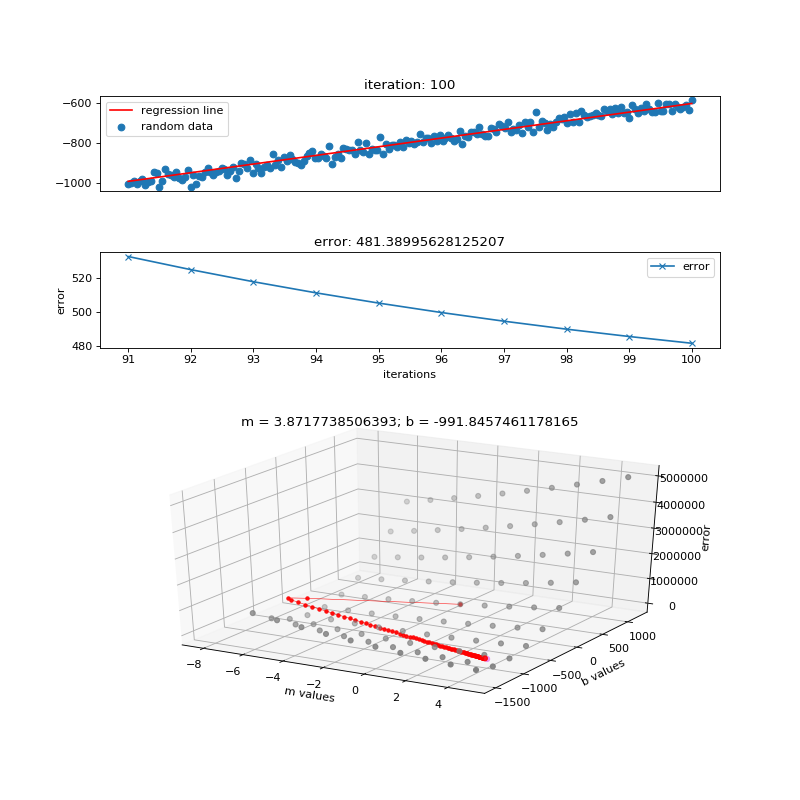

In [121]:
iterations = 100

data_slope, data_intercept = 4, -1000

X, Y = generate_random_data(slope=data_slope, intercept=data_intercept)

f = LinearFunction()

visualise = make_training_visualisation_function(X, Y, f,
                                                target_slope=data_slope,
                                                target_intercept=data_intercept)
visualise(0)
for i in range(iterations):
    update(f, 0.0001, X, Y)
    visualise(i+1)